In [1]:
import csv
import requests
import pandas as pd
import matplotlib
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
from io import BytesIO
from PIL import Image

Loading and opening the dataset with blurbs:

In [2]:
b_books = pd.read_csv('books_with_blurbs.csv', delimiter=',')
b_books.head()

,ISBN,Title,Author,Year,Publisher,Blurb
0,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o..."
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea..."
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...
3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...


In [3]:
b_books.shape

(57510, 6)

In [4]:
b_books.drop_duplicates(subset='Title', keep="first")

,ISBN,Title,Author,Year,Publisher,Blurb
0,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o..."
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea..."
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...
3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...
...,...,...,...,...,...,...
57504,0812511654,Empire Builders (The Grand Tour),Ben Bova,1995,Tor Science Fiction,Dan Randolph never plays by the rules. A hell-...
57505,0451458877,Tainted Trail,Wen Spencer,2002,Roc,"Ukiah Oregon, half-man and half-alien raised b..."
57507,0399148841,The Man With the Red Tattoo (James Bond 007),Raymond Benson,2002,Putnam Publishing Group,On a quiet late-night flight from Tokyo to Lon...
57508,0553578979,"Iron Fist (Star Wars: X-Wing Series, Book 6)",Aaron Allston,1998,Bantam,They are the Rebel Alliance's ultimate strike ...


Loading the data from the Book-Crossing dataset (http://www2.informatik.uni-freiburg.de/~cziegler/BX/).
First, let's look at the "BX-Books" table:

In [5]:
all_books = pd.read_csv('BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
all_books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 
                 'imageUrlS', 'imageUrlM', 'imageUrlL']
all_books.head()

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
c:\users\anastask\appdata\local\programs\python\python37\lib\site-packages

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
all_books.shape

(271360, 8)

In [7]:
merged = pd.merge(b_books, all_books, how='inner', on=['ISBN'])
merged.head()

,ISBN,Title,Author,Year,Publisher,Blurb,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea...",Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...
3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,http://images.amazon.com/images/P/1881320189.0...,http://images.amazon.com/images/P/1881320189.0...,http://images.amazon.com/images/P/1881320189.0...


The resulting dataframe has redundant (repeated) columns. Let's select the columns of interest:

In [8]:
books = merged[['ISBN', 'Title', 'Author', 'Year', 'Publisher', 'Blurb', 'imageUrlL']]
books.head()

,ISBN,Title,Author,Year,Publisher,Blurb,imageUrlL
0,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",http://images.amazon.com/images/P/0060973129.0...
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea...",http://images.amazon.com/images/P/0374157065.0...
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...,http://images.amazon.com/images/P/0399135782.0...
3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...,http://images.amazon.com/images/P/0425176428.0...
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...,http://images.amazon.com/images/P/1881320189.0...


In [9]:
books.shape

(57510, 7)

User analysis:

In [10]:
users = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Book ratings:

In [11]:
all_ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
all_ratings.columns = ['userID', 'ISBN', 'bookRating']
all_ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [12]:
all_ratings.shape

(1149780, 3)

In [13]:
average_rating = pd.DataFrame(all_ratings.groupby('ISBN')['bookRating'].mean())
average_rating['ratingCount'] = pd.DataFrame(all_ratings.groupby('ISBN')['bookRating'].count())
average_rating.sort_values('ratingCount', ascending=False).head()

,bookRating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723


In [14]:
average_rating.shape

(340556, 2)

Combining book data with rating data

In [15]:
books = pd.merge(books, average_rating, how='inner', on=['ISBN'])
books.rename(columns={'bookRating':'averageRating'}, inplace=True)
books.head()

,ISBN,Title,Author,Year,Publisher,Blurb,imageUrlL,averageRating,ratingCount
0,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,"Here, for the first time in paperback, is an o...",http://images.amazon.com/images/P/0060973129.0...,5.000000,3
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea...",http://images.amazon.com/images/P/0374157065.0...,4.272727,11
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...,http://images.amazon.com/images/P/0399135782.0...,4.212121,33
3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...,http://images.amazon.com/images/P/0425176428.0...,1.600000,5
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...,http://images.amazon.com/images/P/1881320189.0...,4.666667,3


In [16]:
books.shape

(57510, 9)

In [17]:
books[['averageRating', 'ratingCount']].describe()

,averageRating,ratingCount
count,57510.000000,57510.000000
mean,4.282205,10.908572
std,2.441994,28.056272
min,0.111111,1.000000
25%,2.470588,2.000000
50%,3.642857,4.000000
75%,5.600000,10.000000
max,10.000000,2502.000000


Some data visualizations:

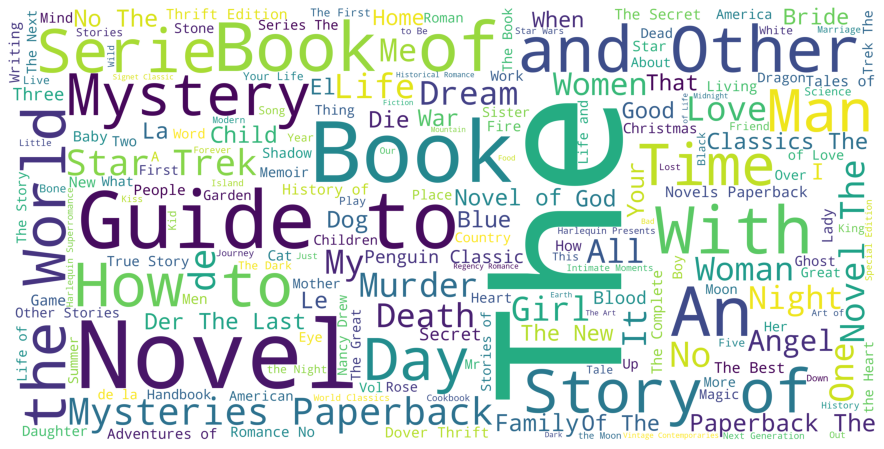

In [56]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

# Create a wordcloud of the movie titles
books['Title'] = books['Title'].fillna("").astype('str')
title_corpus = ' '.join(books['Title'])

new_words = 'Paperback The An amp Book'.split()
stop_words = list(STOPWORDS) + new_words

title_wordcloud = WordCloud(stopwords=stop_words, 
                            background_color='white', height=2000, width=4000).generate(title_corpus)

# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [18]:
# Calculating the word count for blurbs
books['wordCount'] = books['Blurb'].apply(lambda x: len(str(x).split()))
books.head()
# Saving the data into a csv table
path = 'C:/Users/anastask/OneDrive - NTNU/TDT4310/Project/books.csv'
books.to_csv(path, index=False, encoding='utf-8-sig')

In [19]:
books['wordCount'].describe()

count    57510.000000
mean       113.636324
std         80.884984
min          1.000000
25%         52.000000
50%         98.000000
75%        152.000000
max       2679.000000
Name: wordCount, dtype: float64

There is one extreme book blurb consisting of 2679 words (which turned out to be in French) and some amount of books with really short descriptions (with the minimum of one, and it turned out to be some Japanese characters which were perceived as one word). Anyway, since really short blurbs probably are not very informative (or are not proper blurbs at all), let's get rid of those, together with extremely long blurbs. I have set a treshold of 50 words minimum (which is around the first quantile) and 500 words maximum:

In [20]:
books1 = books.loc[books['wordCount'].isin(range(50,500))]
books1.head()

,ISBN,Title,Author,Year,Publisher,Blurb,imageUrlL,averageRating,ratingCount,wordCount
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,"The fascinating, true story of the world's dea...",http://images.amazon.com/images/P/0374157065.0...,4.272727,11,180
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,Winnie and Helen have kept each others worst s...,http://images.amazon.com/images/P/0399135782.0...,4.212121,33,94
3,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,Historians and inquisitive laymen alike love t...,http://images.amazon.com/images/P/0425176428.0...,1.600000,5,63
4,1881320189,Goodbye to the Buttermilk Sky,Julia Oliver,1994,River City Pub,This highly praised first novel by fiction wri...,http://images.amazon.com/images/P/1881320189.0...,4.666667,3,268
5,0440234743,The Testament,John Grisham,1999,Dell,"In a plush Virginia office, a rich, angry old ...",http://images.amazon.com/images/P/0440234743.0...,3.085308,422,152


In [21]:
books1.shape

(44306, 10)

...which still gives us 44 thousands books to analyze. Let's plot the wordcount for the remaining books:

Text(0, 0.5, 'Number of books')

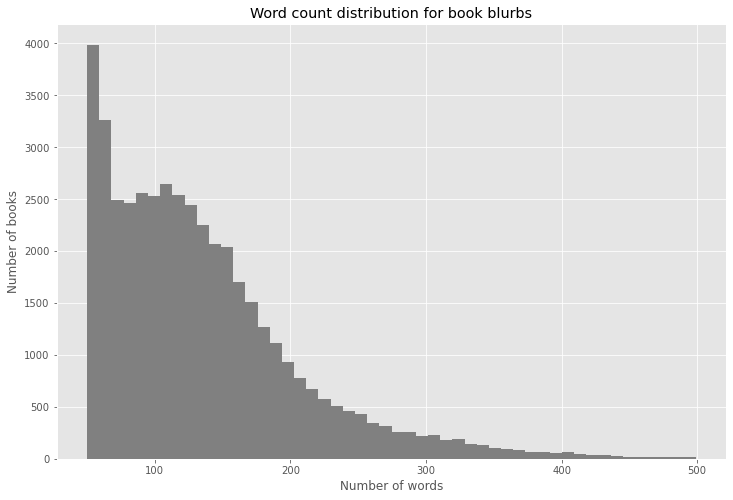

In [22]:
# Plotting the word count
pl = books1['wordCount'].plot(kind='hist', bins=50, figsize=(12,8), color='Grey',
                        title='Word count distribution for book blurbs')
pl.set_xlabel('Number of words')
pl.set_ylabel('Number of books')

In [23]:
# Converting books descriptions into vectors using TF-IDF based on bigrams
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books1['Blurb'])
total_words = tfidf_matrix.sum(axis=0) 

In [24]:
# Finding the word frequency
freq = [(word, total_words[0, idx]) for word, idx in tf.vocabulary_.items()]
freq =sorted(freq, key = lambda x: x[1], reverse=True)

In [25]:
# Converting into dataframe 
bigram = pd.DataFrame(freq)
bigram.rename(columns = {0:'Bigram', 1: 'Count'}, inplace = True)
bigram.head(10)

,Bigram,Count
0,New York,120.909760
1,year old,103.575370
2,years ago,51.151227
3,bestselling author,50.958217
4,This book,50.646997
5,young woman,46.473149
6,York Times,44.124615
7,World War,43.074790
8,best friend,39.114026
9,United States,36.437049


Text(0, 0.5, 'Bigram frequency count')

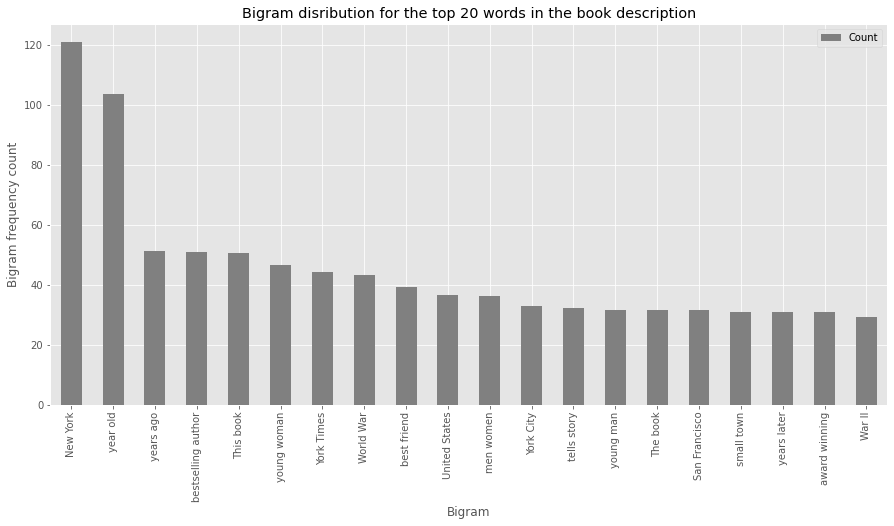

In [26]:
# Taking first 20 records
bigram = bigram.head(20)
#Plotting the bigram distribution
pl2 = bigram.plot(x='Bigram', y='Count', kind='bar', color='Grey',
            title ="Bigram disribution for the top 20 words in the book description", figsize = (15,7), )
pl2.set_ylabel('Bigram frequency count')

Let's pre-process the blurbs for subsequent vectorization: get rid of stop words, punctuation, links, numbers etc.:

In [27]:
# Put text in lowercase, get rid of links, numbers, punctuation, @UserNames(if there are any)
books2 = books1.copy()
books2['cleanedBlurb'] = books2['Blurb'].str.lower()
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'@\w+', '', regex=True)
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'http\S+', '', regex=True)
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'www.[^ ]+', '', regex=True)
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'[0-9]+', '', regex=True)
books2['cleanedBlurb'] = books2['cleanedBlurb'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)

In [28]:
# Remove the stopwords
books2['cleanedBlurb'] = books2['cleanedBlurb'].fillna("").astype('str')
stop_words = set(stopwords.words('english'))
books2['cleanedBlurb'] = books2['cleanedBlurb'].apply(lambda x: ' '.join([word for word in x.split() 
                                                                          if word not in stop_words]))
#books2.head()

When calculating the cosine similarity values between a large number of vectors, one is likely to encounter a memory error due to computing power restrictions of their machine. In my case, I could not compute the similarity matrix for all 44k books - this was too much to run on my machine. Therefore I took a 0.8 sample to analyze, which still gave me 35k books in total (reset the indices in pandas DataFrame to avoid index lookup errors):

In [29]:
books3 = books2.sample(frac=0.8)
books3 = books3.reset_index(drop=True)
books3.shape
#books3.head()

(35445, 11)

Now let's vectorize the book descriptions. This step will take some time:

In [30]:
# Converting books descriptions into vectors using TF-IDF based on bigrams
tf = TfidfVectorizer(ngram_range=(2, 2), stop_words='english', lowercase = False)
tfidf_matrix = tf.fit_transform(books3['cleanedBlurb'])
tfidf_matrix.shape

(35445, 1751275)

Now let's calculate the cosine similarity between vectors (likely to encounter a memory error here if there are too many vectors):

In [31]:
#Function for calculating the cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(35445, 35445)

Let's build a 1-dimensional array of book titles to be able to lookup similar books by typing in their title:

In [32]:
# Build a 1-dimensional array with book titles
titles = books3['Title']
indices = pd.Series(books3.index, index=books3['Title'])
indices.head()

Title
The New Life: A Novel    0
A Man Rides Through      1
True Witness             2
S.                       3
Up Island: A Novel       4
dtype: int64

In [46]:
def recommend(title):
    try:
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6] # let's take five most similar items
        book_indices = [i[0] for i in sim_scores]
        
        recommendations = books3[['Title', 'imageUrlL', 'Author', 'Blurb']].iloc[book_indices] #recommended books
        df = recommendations[['Title', 'Author']]
        print(df.to_string(index=False))
            
        images = []
        for i in recommendations['imageUrlL']:
            response = requests.get(i)
            img = Image.open(BytesIO(response.content))
            images.append(img)
            
        # Ugly piece of code to show images 
        # It needs to be re-written as a function but matplotlib is pain so I will leave it like this for now
        fig = plt.figure()
        a = fig.add_subplot(1, 5, 1)
        imgplot = plt.imshow(images[0])
        a = fig.add_subplot(1, 5, 2)
        imgplot = plt.imshow(images[1])
        a = fig.add_subplot(1, 5, 3)
        imgplot = plt.imshow(images[2])
        a = fig.add_subplot(1, 5, 4)
        imgplot = plt.imshow(images[3])
        a = fig.add_subplot(1, 5, 5)
        imgplot = plt.imshow(images[4])
    except KeyError:
        print('Seems like this book is not in the database. Try another one!')
    

                                                                       Title                   Author
                                        Original Illustrated Sherlock Holmes       Arthur Conan Doyle
                                      The lost adventures of Sherlock Holmes            Ken Greenwald
                                 A Study in Scarlet (New Millennium Library)       Arthur Conan Doyle
                                            Death Wore a Smart Little Outfit           Orland Outland
 Sherlock Holmes : The Complete Novels and Stories (Bantam Classic) Volume I  Arthur Conan, Sir Doyle


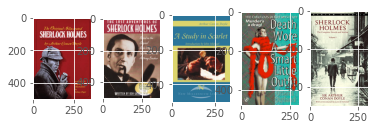

In [47]:
recommend("The Valley of Fear (Sherlock Holmes)")

                                                                               Title            Author
                                                             Emma (Penguin Classics)       Jane Austen
                                                           The Jane Austen Book Club  Karen Joy Fowler
 Eyewitness to America: 500 Years of America in the Words of Those Who Saw It Happen     David Colbert
                                                                 Pride and Prejudice       Jane Austen
                                               Letters from Pemberley the First Year      Jane Dawkins


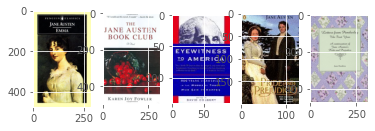

In [48]:
recommend("Bridget Jones's Diary : A Novel")